# ДЗ 2

В этом задании нужно будет обучить архитектуру для задачи Image Classification. Вам нужно будет реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

In [1]:
# Кажется, у меня проблемы с драйверами для видеокарты из-за чего обучение может в произвольный момент падать
# Запрет асинхронных запусков ядра не рашает полностью проблему, но заметно снижает вероятность её возникновения
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

# Dataset

## Download from Kaggle

In [2]:
import zipfile
import shutil
import json
import os

In [3]:
with open('kaggle.json') as f:
    account = json.load(f)
    os.environ['KAGGLE_USERNAME'] = account["username"]
    os.environ['KAGGLE_KEY'] = account["key"]
import kaggle

In [4]:
def clear_directory(path_to_dir: str, force: bool):
    if force and os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    if force or not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)
        return True
    if not os.listdir(path_to_dir):
        return True
    
    return False

In [5]:
def download_dataset_from_kaggle(kaggle_dataset_id: str, out_directory: str, overwrite: bool = False):
    if not clear_directory(out_directory, overwrite):
        print("Directory is already occupied")
        return
    
    kaggle.api.dataset_download_files(kaggle_dataset_id,
                                      path=out_directory,
                                      quiet=False)
    filename = f"{out_directory}/{kaggle_dataset_id.split('/')[-1]}.zip"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(out_directory)
    os.remove(filename)

In [6]:
dataset_name = "slothkong/10-monkey-species"
data_path = "./data"
download_dataset_from_kaggle(dataset_name, data_path)

Directory is already occupied


## Prepare torch dataset

In [7]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from PIL import Image
import random
import cv2

In [8]:
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [9]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class AlbumentationsDataset(ImageFolder):
    def __init__(self, root: str, transform = None):
        super().__init__(root, transform=transform)
        self.imgs = self.samples

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        sample = cv2.imread(path)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            sample = self.transform(image=sample)["image"]
        return sample, target

In [10]:
train_transforms = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Rotate(limit=45),
        A.Resize(224, 224),
        A.Compose([
            A.CenterCrop(155, 155),
            A.Resize(224, 224)
        ], p = 0.3),
        A.OneOf([
            A.Sharpen(),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.05),            
        ], p=0.3),
        A.ToFloat(255),
        ToTensorV2()
])

resnet_train_transforms = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Rotate(limit=45),
        A.Resize(224, 224),
        A.Compose([
            A.CenterCrop(155, 155),
            A.Resize(224, 224)
        ], p = 0.3),
        A.OneOf([
            A.Sharpen(),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.05),            
        ], p=0.3),
        A.ToFloat(255),
        A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ToTensorV2()
])

inception_train_transforms = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Rotate(limit=45),
        A.Resize(518, 518),
        A.Compose([
            A.CenterCrop(358, 358),
            A.Resize(518, 518),
        ], p = 0.3),
        A.OneOf([
            A.Sharpen(),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.05),            
        ], p=0.3),
        A.ToFloat(255),
        A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ToTensorV2()
])

In [11]:
# train_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
#               transforms.RandomHorizontalFlip(),
#               transforms.RandomVerticalFlip(),
#               transforms.CenterCrop(size=(224,224)),
#               transforms.ToTensor()
#         ])

val_transforms = transforms.Compose([
              transforms.Resize(size=(224,224)),
              transforms.ToTensor()
        ])

resnet_val_transforms = transforms.Compose([transforms.Resize((224,224)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

inception_val_transforms = transforms.Compose([transforms.Resize((518,518)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

In [12]:
train_ds = ImageFolder('./data/training/training/', transform=val_transforms)
val_ds = ImageFolder('./data/validation/validation/', transform=val_transforms)

In [13]:
resnet_train_ds = ImageFolder('./data/training/training/', transform=resnet_val_transforms)
resnet_val_ds = ImageFolder('./data/validation/validation/', transform=resnet_val_transforms)

In [14]:
inception_train_ds = ImageFolder('./data/training/training/', transform=inception_val_transforms)
inception_val_ds = ImageFolder('./data/validation/validation/', transform=inception_val_transforms)

In [15]:
print(f'Class statistics in train dataset: {Counter(train_ds.targets)}')
print(f'Class statistics in train dataset: {Counter(val_ds.targets)}')

Class statistics in train dataset: Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Class statistics in train dataset: Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


# Dataloader

In [16]:
CONFIG = {"lr": 1e-5,
          "batch_size": 32,
          "epochs": 100,
          "div_factor": 1e+5}

In [17]:
train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4)

In [18]:
resnet_train_dl = DataLoader(resnet_train_ds, batch_size=16, shuffle=True, num_workers=4)
resnet_val_dl = DataLoader(resnet_val_ds, batch_size=16, shuffle=False, num_workers=4)

In [19]:
inception_train_dl = DataLoader(inception_train_ds, batch_size=4, shuffle=True, num_workers=4)
inception_val_dl = DataLoader(inception_val_ds, batch_size=4, shuffle=False, num_workers=4)

In [20]:
id2clas = {i:q for q,i in train_ds.class_to_idx.items()}

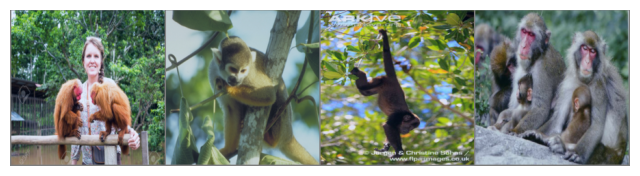

['n2', 'n7', 'n0', 'n3']


In [21]:
NUM_IMAGES = 4
samples = [train_ds[idx] for idx in np.random.randint(0, len(train_ds), 4)]
images = [i[0] for i in samples]
labels = [id2clas[i[1]] for i in samples]

img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()
print(labels)

## VGG.

Реализуйте VGG16 from scratch. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (resnet, ViT???) - делайте, будет учтено.

Что будет оцениваться в задании:
* VGG16 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

In [22]:
class VGG16(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4, num_epochs=10, steps_per_epoch=35, div_factor=1e+3):
        super().__init__()
        self.save_hyperparameters()
        self.num_epochs = num_epochs
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.lr = lr
        self.num_classes = num_classes
        self.model = nn.Sequential(
          nn.Conv2d(3,64,3),
          nn.ReLU(),
          nn.Conv2d(64,64,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d((112, 112)),
          nn.Conv2d(64,128,3),
          nn.ReLU(),
          nn.Conv2d(128,128,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d((56, 56)),
          nn.Conv2d(128,256,3),
          nn.ReLU(),
          nn.Conv2d(256,256,3),
          nn.ReLU(),
          nn.Conv2d(256,256,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d((28, 28)),
          nn.Conv2d(256,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d((14, 14)),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.Conv2d(512,512,3),
          nn.ReLU(),
          nn.AdaptiveMaxPool2d((7, 7)),
          nn.Flatten(),
          nn.Linear(25088, 4096),
          nn.ReLU(),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Linear(4096, num_classes),
          nn.ReLU()
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            epochs=self.num_epochs,
            steps_per_epoch=self.steps_per_epoch,
            max_lr=self.lr,
            pct_start=0.1,
            anneal_strategy='linear',
            final_div_factor=self.div_factor
        )
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('train_loss', loss.item(), on_step=False, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)

# Downloaded models

In [23]:
class ResNet50(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes
        self.model = models.resnet50(weights="IMAGENET1K_V2")
        in_feat = list(self.model.children())[-1].in_features
        self.model.fc = nn.Linear(in_feat, num_classes)
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('train_loss', loss.item(), on_step=False, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch        
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test_acc', acc, on_epoch=True,prog_bar=True)

In [24]:
class InceptionV3(pl.LightningModule):
    def __init__(self, num_classes, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes
        self.model = models.inception_v3(weights="IMAGENET1K_V1")
        self.model.AuxLogits.fc = nn.Linear(768, num_classes)
        self.model.fc = nn.Linear(2048, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs, aux_outputs = self(x)
        loss1 = self.loss_fn(outputs, y)
        loss2 = self.loss_fn(aux_outputs, y)
        loss = loss1 + 0.4*loss2
        acc = self.accuracy(torch.argmax(outputs, dim=1), y)
        self.log('train_loss', loss.item(), on_step=False, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x,y = batch        
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)ImageFolder
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        preds = self(x)
        acc = self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test_acc', acc, on_epoch=True,prog_bar=True)

# Train

## From zero

In [25]:
vgg_model = VGG16(num_classes = 10, 
              num_epochs = CONFIG['epochs'], 
              steps_per_epoch = len(train_dl),
              lr = CONFIG['lr'],
              div_factor = CONFIG['div_factor'])
trainer_args = {
        "accelerator": "gpu",
        "max_epochs": CONFIG['epochs'],
        "default_root_dir": "vgg16/",
    }
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.fit(vgg_model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 134 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Fine-tuning

In [26]:
resnet_model = ResNet50(num_classes = 10, lr = 2e-4)
resnet_trainer_args = {
        "accelerator": "gpu",
        "max_epochs": 30,
        "default_root_dir": "resnet50/",
    }
resnet_trainer = pl.Trainer(**resnet_trainer_args, enable_progress_bar=True)
resnet_trainer.fit(resnet_model, resnet_train_dl, resnet_val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNet             | 23.5 M
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [27]:
inception_model = InceptionV3(num_classes = 10, lr = 2e-4)
inception_trainer_args = {
        "accelerator": "gpu",
        "max_epochs": 30,
        "default_root_dir": "inception/",
    }
inception_trainer = pl.Trainer(**inception_trainer_args, enable_progress_bar=True)
inception_trainer.fit(inception_model, inception_train_dl, inception_val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Inception3         | 24.4 M
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.486    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


# Test and metrics

In [28]:
metrics_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc']

In [29]:
from pathlib import Path
import re


def get_version(path: Path):
    pattern = re.compile(r'version_(\d+)$')
    match = pattern.match(str(path.name))
    if match is not None:
        return int(match.group(1))
    return -1

def get_most_recent_tensorboard_log(root_path = "./"):
    root_path = Path(root_path)
    log_dirs = sorted([(get_version(p), p) for p in root_path.iterdir() if p.is_dir()])
    return log_dirs[-1][1].glob("events.out.*").__next__().__str__()

In [30]:
from tensorboard.backend.event_processing import event_accumulator
from typing import Iterable, Dict
import pandas as pd


def parse_tensorboard(path: str, scalars: Iterable):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k))["value"].to_numpy() for k in scalars}

In [31]:
def plot_tensoarboard_graphics(data: Dict[str, np.ndarray]):
    subplots = [['val_loss', 'train_loss'],
                ['val_acc', 'train_acc']]
    subplots_titles = [("История ошибки", "Ошибка"),
                       ("История точности", "Точность")]
    labels = {'train_loss': 'Train',
              'train_acc': 'Train',
              'val_loss': 'Valid',
              'val_acc': 'Valid'}

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, (scalar_names, (title, y_label)) in enumerate(zip(subplots, subplots_titles)):
        for name in scalar_names:
            axes[i].plot(list(range(1, 1 + len(data[name]))),
                         data[name], label=labels[name])
        
        axes[i].set_title(title)
        axes[i].set_xlabel("Эпоха")
        axes[i].set_ylabel(y_label)
        axes[i].grid(ls=':')
        axes[i].legend()
    plt.show()


## VGG 16

In [32]:
last_vgg_log_path = get_most_recent_tensorboard_log("./vgg16/lightning_logs")
log_scalars = parse_tensorboard(last_vgg_log_path, metrics_list)

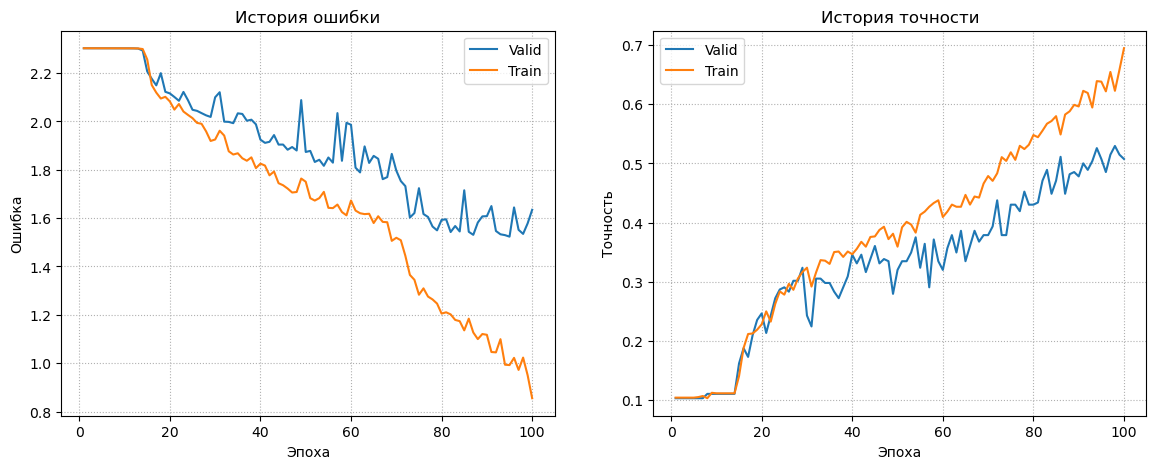

In [33]:
plot_tensoarboard_graphics(log_scalars)

## ResNet50

In [34]:
last_resnet_log_path = get_most_recent_tensorboard_log("./resnet50/lightning_logs")
log_scalars = parse_tensorboard(last_resnet_log_path, metrics_list)

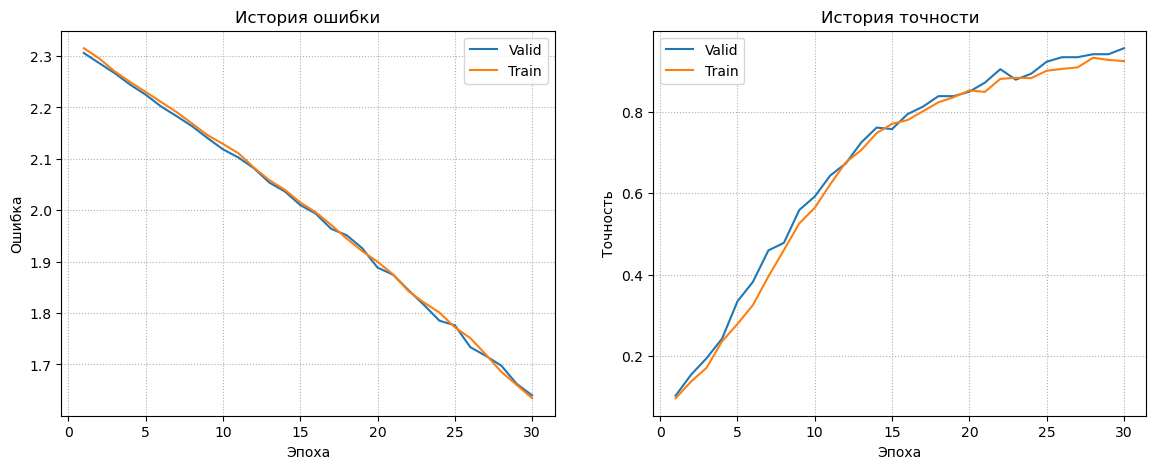

In [35]:
plot_tensoarboard_graphics(log_scalars)

## InceptionV3

In [36]:
last_inception_log_path = get_most_recent_tensorboard_log("./inception/lightning_logs")
log_scalars = parse_tensorboard(last_inception_log_path, metrics_list)

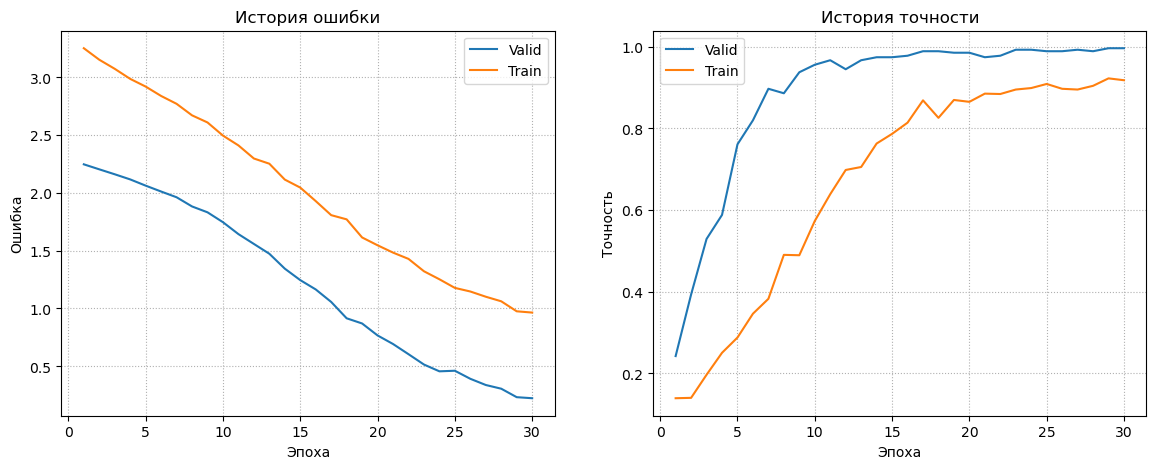

In [37]:
plot_tensoarboard_graphics(log_scalars)

# Summary